<a href="https://colab.research.google.com/github/yoineko/skillfactory-module6/blob/master/baseline_keras_xception_car_class_v2_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> Это пример решения задачи с использованием Keras. Вы можете использовать этот кернер для дальнейших исследований и экспериментов.
# Классификация изображений

### Основная идея этого решения: взять предобученую на ImageNet сеть Xception и дообучить под нашу задачу. 
По ходу решения мы будем давать вам рекомендации, которые помогут улучшить качество модели. 


Удачи и Поехали!

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR = '/content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!nvidia-smi

Sat Aug 22 04:32:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.efficientnet import EfficientNetB6, EfficientNetB7
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(os.listdir("../input"))
print(os.listdir(DIR + "input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['sample-submission.csv', 'test.zip', 'train.csv', 'train.zip', 'train.gsheet', 'sample-submission.gsheet']
Python       : 3.6.9 (default, Jul 17 2020, 12:50:27) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0
Keras        : 2.4.0


**Работаем с Tensorflow v2**

In [ ]:
!pip freeze > requirements.txt

# Основные настройки

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.

EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 8 #32 #64 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 250 #350 #224 # начнем с малого 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

# DATA_PATH = '../input/'
# PATH = "../working/car/" # рабочая директория

DATA_PATH =  DIR + 'input/'
PATH = DIR + "working/car/" # рабочая директория
ver = '6_4'

In [ ]:
# Устаналиваем конкретное значение random seed для воспроизводимости
#os.makedirs(PATH,  exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# EDA / Анализ данных

In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
#train_df.head()

In [ ]:
#train_df.info()

In [ ]:
#train_df.Category.value_counts()
# распределение классов достаточно равномерное - это хорошо

In [ ]:
# print('Распаковываем картинки')
# # Will unzip the files so that you can see them..
# for data_zip in ['train.zip', 'test.zip']:
#     #with zipfile.ZipFile("../input/"+data_zip,"r") as z:
#     with zipfile.ZipFile(DIR + "/input/"+data_zip,"r") as z:  
#         z.extractall(PATH)
        
# print(os.listdir(PATH))

In [ ]:
# print('Пример картинок (random sample)')
# plt.figure(figsize=(12,8))

# random_image = train_df.sample(n=9)
# random_image_paths = random_image['Id'].values
# random_image_cat = random_image['Category'].values

# for index, path in enumerate(random_image_paths):
#     im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
#     plt.subplot(3,3, index+1)
#     plt.imshow(im)
#     plt.title('Class: '+str(random_image_cat[index]))
#     plt.axis('off')
# plt.show()

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

In [ ]:
# image = PIL.Image.open(PATH+'/train/0/100380.jpg')
# imgplot = plt.imshow(image)
# plt.show()
# image.size

### Уже догадываетесь, что означают классы?

# Подготовка данных

### Аугментация данных

In [ ]:
# Вы помните, что аугментация данных важна, когда мы работаем с небольшим датасетом. Это как раз наш случай.
# Чтобы лучше понять работу параметров, попробуйте их изменить. К какому результату это приведет?
# Официальная документация: https://keras.io/preprocessing/image/

# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     rotation_range = 5,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     validation_split=VAL_SPLIT, # set validation split
#     horizontal_flip=False)

#test_datagen = ImageDataGenerator(rescale=1. / 255)

#Рекомендация Подключите более продвинутые библиотеки аугментации изображений (например: albumentations или imgaug, для них есть специальные "обертки" под Keras, например: https://github.com/mjkvaak/ImageDataAugmentor)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.3,
    fill_mode='reflect'
    )

test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.5,1.5],
    shear_range=0.1,
    zoom_range=0.3,
    fill_mode='reflect'
    )

### Генерация данных

In [ ]:
# Завернем наши данные в генератор:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

#test_sub_generator = test_datagen.flow_from_dataframe( 
test_sub_generator = train_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

# Обратите внимание, что для сабмита мы используем другой источник test_datagen.flow_from_dataframe. Как вы думаете, почему?

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# Построение модели

### Загружаем предобученную сеть Xception:

In [ ]:
# чистит сессию в Keras и TF
def reset_tf_session():
    curr_session = tf.compat.v1.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.compat.v1.InteractiveSession(config=config)
 #   K.set_session(s)
    tf.compat.v1.keras.backend.set_session(s)

s = reset_tf_session()

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))
 
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
 
    plt.figure()
 
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
 
    plt.show()

In [ ]:
#base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
#base_model = EfficientNetB6(weights='imagenet', include_top=False, input_shape = input_shape)
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

258080768/258076736 [==============================] - 2s 0us/step


In [ ]:
#base_model.summary()
# Рекомендация: Попробуйте и другие архитектуры сетей

In [ ]:
# Устанавливаем новую "голову" (head)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# # x = Dropout(0.25)(x)
# # let's add a fully-connected layer
# x = Dense(256, activation='relu')(x)
# # x = Dropout(0.25)(x)
# # x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Dropout(0.25)(x)
# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# #model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# # Устанавливаем новую "голову" (head)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = BatchNormalization()(x)
# # let's add a fully-connected layer
# x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# x = BatchNormalization()(x)
# #x = Dropout(0.25)(x)
# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
#base_model.trainable = False

In [ ]:
# # Устанавливаем новую "голову" (head)

# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dropout(0.25)(x)
# # let's add a fully-connected layer
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.25)(x)
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.25)(x)

# # and a logistic layer -- let's say we have 10 classes
# predictions = Dense(CLASS_NUM, activation='softmax')(x)

# # this is the model we will train
# model = Model(inputs=base_model.input, outputs=predictions)
# #model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [ ]:
# Устанавливаем новую "голову" (head)

x = base_model.output

x = Conv2D(512, kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)

x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
# let's add a fully-connected layer
x = Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)

# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Сконфигурируем модель для категориальной классификации.
#model.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(lr=LR), metrics=["accuracy"])

#model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=LR, momentum=0.9), metrics=["accuracy"])

In [ ]:
#model.summary()
# Рекомендация: Попробуйте добавить Batch Normalization

## Обучение модели

Добавим ModelCheckpoint чтоб сохранять прогресс обучения модели и можно было потом подгрузить и дообучить модель.

In [ ]:
checkpoint = ModelCheckpoint(DIR + f'best_model/best_model{ver}.hdf5' , monitor = 'val_accuracy' , verbose = 1  , save_best_only = True, mode = 'max')
earlystop = EarlyStopping(patience=5, monitor='val_loss') #, restore_best_weights=True)
callbacks_list = [checkpoint, earlystop]

# Рекомендация 1. Добавьте другие функции из https://keras.io/callbacks/
# Рекомендация 2. Используйте разные техники управления Learning Rate
# https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng)
# http://teleported.in/posts/cyclic-learning-rate/ (eng)

In [ ]:
# mode_train False - all layers frezee, True - all layers not frezee
def config_model(mode_train, l_r, ephochs,  fine_tune_at = 0):
    base_model.trainable = mode_train
    if fine_tune_at > 0 :

# Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable =  False

    model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=l_r), metrics=["accuracy"])

    scores = model.evaluate_generator(test_generator, steps=1, verbose=1)
    print("Accuracy before fit: %.2f%%" % (scores[1]*100))

    history =    model.fit(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = ephochs,
        callbacks = callbacks_list
       )
    
    # сохраним итоговую сеть и подгрузим лучшую итерацию в обучении (best_model)
    model.save(DIR + f'working/model_last{ver}.hdf5')

    model.load_weights(DIR +f'best_model/best_model{ver}.hdf5')

    scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
    print("Accuracy after: %.2f%%" % (scores[1]*100))

    plot_history(history)

Instructions for updating:
Please use Model.evaluate, which supports generators.
1/1 [==============================] - 0s 3ms/step - loss: 2.1601 - accuracy: 0.1250
Accuracy before fit: 12.50%
Epoch 1/5
1654/1654 [==============================] - ETA: 0s - loss: 2.3112 - accuracy: 0.1172
Epoch 00001: val_accuracy improved from -inf to 0.12666, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_4.hdf5
1654/1654 [==============================] - 3803s 2s/step - loss: 2.3112 - accuracy: 0.1172 - val_loss: 2.2930 - val_accuracy: 0.1267
Epoch 2/5
1654/1654 [==============================] - ETA: 0s - loss: 2.2941 - accuracy: 0.1261
Epoch 00002: val_accuracy did not improve from 0.12666
1654/1654 [==============================] - 357s 216ms/step - loss: 2.2941 - accuracy: 0.1261 - val_loss: 2.2924 - val_accuracy: 0.1267
Epoch 3/5
1654/1654 [==============================] - ETA: 0s - loss: 2.2934 - accuracy: 0.1262
Epoch 00003: val_accura

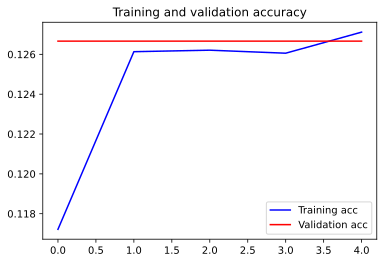

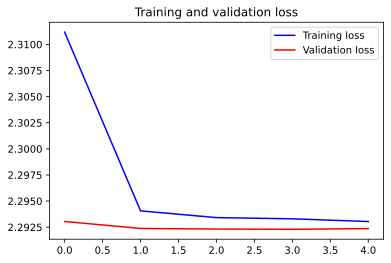

In [ ]:
# train only head
# step 1 
config_model(False, l_r = 1e-3, ephochs = 5,   fine_tune_at = 0)

In [ ]:
# Let's take a look to see how many layers are in the base model
base_layers = len(base_model.layers)
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  813


1/1 [==============================] - 0s 2ms/step - loss: 2.3086 - accuracy: 0.0000e+00
Accuracy before fit: 0.00%
Epoch 1/10
1654/1654 [==============================] - ETA: 0s - loss: 2.2940 - accuracy: 0.1245
Epoch 00001: val_accuracy did not improve from 0.12666
1654/1654 [==============================] - 391s 236ms/step - loss: 2.2940 - accuracy: 0.1245 - val_loss: 2.2929 - val_accuracy: 0.1267
Epoch 2/10
1654/1654 [==============================] - ETA: 0s - loss: 2.2936 - accuracy: 0.1262
Epoch 00002: val_accuracy did not improve from 0.12666
1654/1654 [==============================] - 390s 236ms/step - loss: 2.2936 - accuracy: 0.1262 - val_loss: 2.2927 - val_accuracy: 0.1267
Epoch 3/10
1654/1654 [==============================] - ETA: 0s - loss: 2.2941 - accuracy: 0.1267
Epoch 00003: val_accuracy did not improve from 0.12666
1654/1654 [==============================] - 390s 236ms/step - loss: 2.2941 - accuracy: 0.1267 - val_loss: 2.2926 - val_accuracy: 0.1267
Epoch 4/10
165

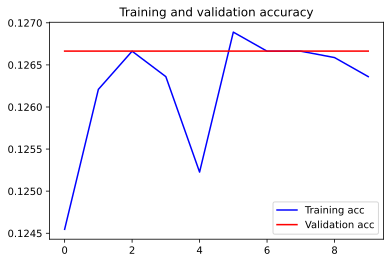

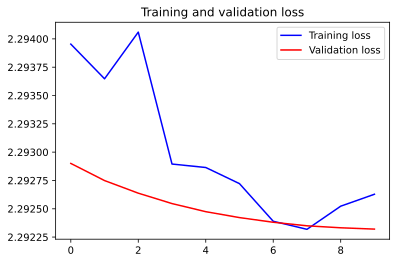

In [ ]:
# step 2 
config_model( True, l_r = 1e-4, ephochs = 10,  fine_tune_at = base_layers//2)

1/1 [==============================] - 0s 2ms/step - loss: 2.2641 - accuracy: 0.3750
Accuracy before fit: 37.50%
Epoch 1/10
1654/1654 [==============================] - ETA: 0s - loss: 2.2929 - accuracy: 0.1267
Epoch 00001: val_accuracy did not improve from 0.12666
1654/1654 [==============================] - 794s 480ms/step - loss: 2.2929 - accuracy: 0.1267 - val_loss: 2.2930 - val_accuracy: 0.1267
Epoch 2/10
1654/1654 [==============================] - ETA: 0s - loss: 2.2930 - accuracy: 0.1269
Epoch 00002: val_accuracy did not improve from 0.12666
1654/1654 [==============================] - 794s 480ms/step - loss: 2.2930 - accuracy: 0.1269 - val_loss: 2.2930 - val_accuracy: 0.1267
Epoch 3/10
1654/1654 [==============================] - ETA: 0s - loss: 2.2326 - accuracy: 0.1308
Epoch 00003: val_accuracy improved from 0.12666 to 0.13783, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_4.hdf5
1654/1654 [==============================

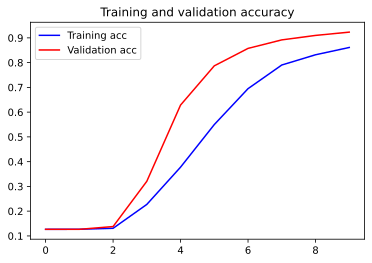

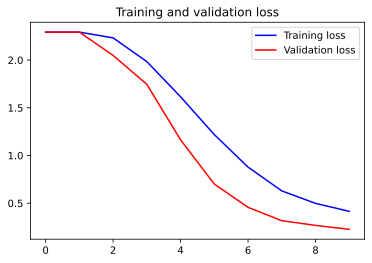

In [ ]:
# step 3 
config_model( True, l_r = 1e-5, ephochs = 10,  fine_tune_at =0 ) #base_layers//4)

In [ ]:
# step 4 
#config_model(model, True, l_r = 0.00001, ephochs = 10,  fine_tune_at = base_layers//8)

In [ ]:
# step 5 
#config_model(model, True, l_r = 0.000006, ephochs = 10 ,  fine_tune_at = 0)

In [ ]:
# step 6
IMG_SIZE             = 350 
BATCH_SIZE           = 4

model.load_weights(DIR +f'best_model/best_model{ver}.hdf5')

config_model( True, l_r = 1e-5, ephochs = 10 ,  fine_tune_at = 0)

1/1 [==============================] - 0s 3ms/step - loss: 0.2949 - accuracy: 0.8750
Accuracy before fit: 87.50%
Epoch 1/10
1654/1654 [==============================] - ETA: 0s - loss: 0.3430 - accuracy: 0.8841
Epoch 00001: val_accuracy improved from 0.92314 to 0.93001, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_4.hdf5
1654/1654 [==============================] - 802s 485ms/step - loss: 0.3430 - accuracy: 0.8841 - val_loss: 0.1951 - val_accuracy: 0.9300
Epoch 2/10
1654/1654 [==============================] - ETA: 0s - loss: 0.2922 - accuracy: 0.8994
Epoch 00002: val_accuracy improved from 0.93001 to 0.93259, saving model to /content/drive/My Drive/Colab Notebooks/Data_Sceince/Module_6/best_model/best_model6_4.hdf5
1654/1654 [==============================] - 802s 485ms/step - loss: 0.2922 - accuracy: 0.8994 - val_loss: 0.1982 - val_accuracy: 0.9326
Epoch 3/10
1654/1654 [==============================] - ETA: 0s - loss: 0.2549 - 

In [ ]:

# model.load_weights(DIR +f'best_model/best_model4_1.hdf5')

# scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
# print("Accuracy after: %.2f%%" % (scores[1]*100))

# step 4 
#config_model(model, True, l_r = 0.000006, ephochs = 20 , steps_per_epoch= len(train_generator), validation_steps= len(test_generator),  fine_tune_at = 0)

# Предсказание на тестовых данных

In [ ]:
test_sub_generator.samples

In [ ]:
# test_sub_generator.reset()
# predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
# predictions = np.argmax(predictions, axis=-1) #multiple categories
# label_map = (train_generator.class_indices)
# label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
# predictions = [label_map[k] for k in predictions]

In [ ]:
from tqdm import tqdm

test_sub_generator.reset()
tta_steps = 10
l_predictions = []

for i in tqdm(range(tta_steps)):
#    preds = model.predict_generator(train_datagen.flow(x_val, batch_size=bs, shuffle=False), steps = len(x_val)/bs)
    preds = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    l_predictions.append(preds)

pred = np.mean(l_predictions, axis=0)

#np.mean(np.equal(np.argmax(y_val, axis=-1), np.argmax(pred, axis=-1)))

predictions = np.argmax(pred, axis=-1)
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
# l_predictions[0].any()==l_predictions[2].any()
# l_predictions[0][:10]== l_predictions[1][:10]

In [ ]:
# l_predictions[0][3], '/n',l_predictions[1][3],'/n', l_predictions[2][3],'/n',(l_predictions[0][3]+l_predictions[1][3]+ l_predictions[2][3])/3

In [ ]:
#pred[3]

In [ ]:
#l_predictions[1][:10]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv(DIR + f'submission/submission_{ver}.csv', index=False)
print('Save submit')

# Рекомендация: попробуйте добавить Test Time Augmentation (TTA)
# https://towardsdatascience.com/test-time-augmentation-tta-and-how-to-perform-it-with-keras-4ac19b67fb4d

In [ ]:
submission.head()

In [ ]:
#tmp_y = pd.concat([submission['Category']])

In [ ]:
#filenames_with_dir

In [ ]:
# Clean PATH
# import shutil
# shutil.rmtree(PATH)

## Интересно, к какому классу модель отнесет вот эти автомобили?

# Что можно сделать, чтобы улучшить результат:

* Примените transfer learning с fine-tuning
* Настройте LR, optimizer, loss
* Подберите другие переменные (размер картинки, батч и т.д.)
* Попробуйте и другие архитектуры сетей (а не только Xception) или их ансамбли. Примеры SOTA на ImageNet  
* 
* Добавьте Batch Normalization и поэкспериментируйте с архитектурой “головы”
* Примените другие функции callback Keras https://keras.io/callbacks/ 
* Добавьте TTA (Test Time Augmentation)
* Дополнительно*: Используйте разные техники управления Learning Rate (https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6 (eng) http://teleported.in/posts/cyclic-learning-rate/ (eng))
* Дополнительно*: Добавьте более продвинутые библиотеки аугментации изображений (например, Albumentations )

### Удачи в соревновании!